# mlreflect usage example

In [1]:
%load_ext autoreload

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

import mlreflect

from mlreflect import ReflectivityGenerator, InputPreprocessor, OutputPreprocessor, Prediction, Layer, MultilayerStructure
from mlreflect import h5_tools
from mlreflect.models.simple_model import SimpleModel
from mlreflect.models.model_helpers import create_save_directory
from mlreflect import check_gpu

print('Tested with mlreflect version: ' + mlreflect.__version__)

Tested with mlreflect version: 0.14.0


In [3]:
check_gpu()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load experimental data
In this case DIP_303K.dat contains columns of reflectivity data with the first column containing the q-values in units 1/A

In [4]:
experiment = np.loadtxt('DIP_303K.dat')

In [5]:
q = experiment[9:, 0] # Extract q-values
experimental_reflectivity = experiment[9:, 1:].T

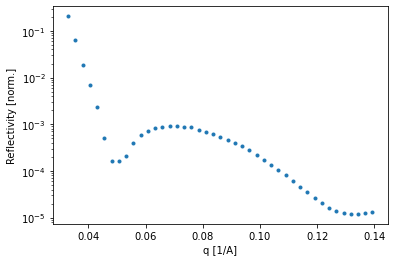

In [6]:
plt.semilogy(q, experimental_reflectivity[30, :], '.')
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Generate random training data
Choose parameter ranges for the randomly generated training data with mininimum and maximum values for each layer using Layer objects.

In [7]:
layer1 = Layer('Si', (1, 1), (1, 1), (20.1, 20.1))
layer2 = Layer('SiOx', (2.8, 30), (2.5, 2.5), (17.8, 17.8))
layer3 = Layer('Film', (20, 300), (0, 60), (1, 14))

The layers are then added to a MultilayerStructure

In [8]:
sample = MultilayerStructure(ambient_sld_range=(0, 0)) # Initialize MultilayerStructure object with ambient SLD of 0 (air for X-ray)
sample.add_layer(layer1)
sample.add_layer(layer2)
sample.add_layer(layer3)

In [9]:
print(sample)

ambient_sld: 0  -- 0 [1e-6 1/Å^2]
[2] Film:
	thickness: 20 -- 300 [Å]
	roughness: 0 -- 60 [Å]
	sld: 1 -- 14 [1e-6 1/Å^2]
[1] SiOx:
	thickness: 2.8 -- 30 [Å]
	roughness: 2.5 -- 2.5 [Å]
	sld: 17.8 -- 17.8 [1e-6 1/Å^2]
[0] Si:
	thickness: 1 -- 1 [Å]
	roughness: 1 -- 1 [Å]
	sld: 20.1 -- 20.1 [1e-6 1/Å^2]



In [10]:
gen = ReflectivityGenerator(q, sample, random_seed=10) # Initialize ReflectivityGenerator using the previously constructed sample
random_labels = gen.generate_random_labels(22500)

Finished 'generate_random_labels' in 0.1342 secs


In [11]:
random_labels.head() # Quick inspection if the generated parameters are as expected

,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,ambient_sld
0,22.406565,230.024905,1.0,2.5,51.631668,20.1,17.8,4.008062,0.0
1,23.866974,257.171442,1.0,2.5,5.936405,20.1,17.8,6.093867,0.0
2,3.399917,146.485757,1.0,2.5,52.753262,20.1,17.8,5.066727,0.0
3,6.942936,274.775409,1.0,2.5,17.326658,20.1,17.8,3.026910,0.0
4,28.716304,247.493029,1.0,2.5,42.149892,20.1,17.8,3.623453,0.0


In [12]:
random_reflectivity = gen.simulate_reflectivity(random_labels) # Simulate reflectivity using the generated parameters

100%|██████████| 22500/22500 [00:01<00:00, 19463.85it/s]

Finished 'simulate_reflectivity' in 1.2356 secs


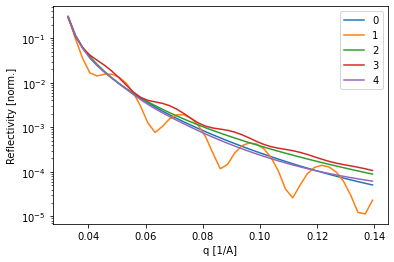

In [13]:
for i in range(5):
    plt.semilogy(q, random_reflectivity[i, :], label=str(i))
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.legend()
plt.show()

In [14]:
sld_profiles = gen.simulate_sld_profiles(random_labels[0:5]) # Simulate SLD profile for visual inspection

100%|██████████| 5/5 [00:00<00:00, 1971.38it/s]

Finished 'simulate_sld_profiles' in 0.0050 secs


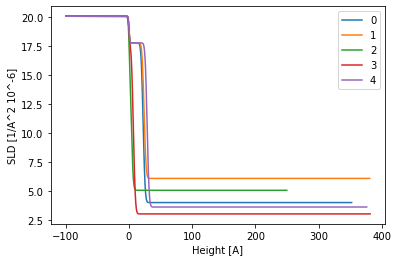

In [15]:
for i in range(5):
    plt.plot(sld_profiles[i][0, :], sld_profiles[i][1, :], label=str(i))
plt.xlabel('Height [A]')
plt.ylabel('SLD [1/A^2 10^-6]')
plt.legend()
plt.show()

Write data to an h5 file so it can be reused later.

Split labels and reflectivity into training, validation and testing sets. Since labels are saved as a pandas DataFrame, the index must be dropped.

In [16]:
# create_save_directory('output/')
# h5_tools.save_data_as_h5('output/saved_training_data.h5', q, random_reflectivity, random_labels, number_of_layers=3)

In [17]:
# loaded_data = h5_tools.read_from_h5('output/saved_training_data.h5') # Data can be loaded like this

In [18]:
train_labels = random_labels[:20000].reset_index(drop=True)
val_labels = random_labels[20000:22000].reset_index(drop=True)
test_labels = random_labels[22000:].reset_index(drop=True)

In [19]:
train_reflectivity = random_reflectivity[:20000, :]
val_reflectivity = random_reflectivity[20000:22000, :]
test_reflectivity = random_reflectivity[22000:, :]

### Train neural network

Apply preprocessing to the input data.

In [20]:
ip = InputPreprocessor()

In [21]:
train_reflectivity_pp = ip.standardize(train_reflectivity)
val_reflectivity_pp = ip.standardize(val_reflectivity)
test_reflectivity_pp = ip.standardize(test_reflectivity)

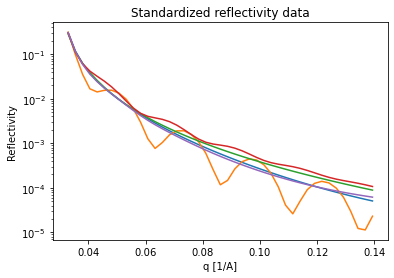

In [22]:
for i in range(5):
    plt.semilogy(q, train_reflectivity[i, :])
plt.title('Standardized reflectivity data')
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity')
plt.show()

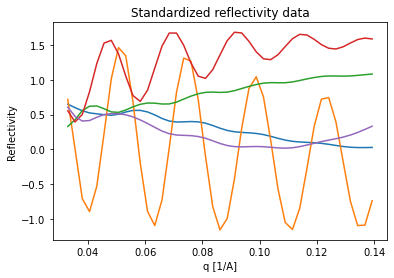

In [23]:
for i in range(5):
    plt.plot(q, train_reflectivity_pp[i, :])
plt.title('Standardized reflectivity data')
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity')
plt.show()

Initialize OutputPreprocessor object with the predefined sample and apply preprocessing to the labels.

In [24]:
op = OutputPreprocessor(sample, normalization='min_to_zero')

train_labels_pp, removed_train_labels = op.apply_preprocessing(train_labels)
val_labels_pp, removed_val_labels = op.apply_preprocessing(val_labels)
test_labels_pp, removed_test_labels = op.apply_preprocessing(test_labels)

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


In [25]:
train_labels_pp.head()

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.720830,0.750089,0.860528,0.231389
1,0.774521,0.847041,0.098940,0.391836
2,0.022056,0.451735,0.879221,0.312825
3,0.152314,0.909912,0.288778,0.155916
4,0.952805,0.812475,0.702498,0.201804


Train the neural network using the model defined in SimpleModel and save results in 'output/simple_model/'.

In [26]:
path = os.path.join('output', 'simple_model')

In [27]:
simple_model = SimpleModel(path, train_reflectivity_pp.shape[1], train_labels_pp.shape[1])
hist, timestamp = simple_model.train(train_reflectivity_pp, train_labels_pp, val_reflectivity_pp, val_labels_pp)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               17600     
_________________________________________________________________
activation (Activation)      (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               320800    
_________________________________________________________________
activation_1 (Activation)    (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               1

Epoch 24/60
15872/20000 [======================>.......] - ETA: 0s - loss: 0.0030
Epoch 00024: val_loss did not improve from 0.00306
20000/20000 [==============================] - 0s 11us/sample - loss: 0.0030 - val_loss: 0.0035
Epoch 25/60
19712/20000 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00025: val_loss improved from 0.00306 to 0.00296, saving model to output/simple_model/models/2020-07-30-173124.h5
20000/20000 [==============================] - 0s 14us/sample - loss: 0.0028 - val_loss: 0.0030
Epoch 26/60
17152/20000 [========================>.....] - ETA: 0s - loss: 0.0027
Epoch 00026: val_loss did not improve from 0.00296
20000/20000 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0040
Epoch 27/60
17152/20000 [========================>.....] - ETA: 0s - loss: 0.0027
Epoch 00027: val_loss did not improve from 0.00296
20000/20000 [==============================] - 0s 10us/sample - loss: 0.0028 - val_loss: 0.0044
Epoch 28/60
199

20000/20000 [==============================] - 0s 12us/sample - loss: 0.0011 - val_loss: 0.0018
Epoch 58/60
16896/20000 [========================>.....] - ETA: 0s - loss: 0.0011    
Epoch 00058: val_loss did not improve from 0.00182
20000/20000 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0022
Epoch 59/60
16128/20000 [=======================>......] - ETA: 0s - loss: 9.6519e-04
Epoch 00059: val_loss did not improve from 0.00182
20000/20000 [==============================] - 0s 10us/sample - loss: 9.4808e-04 - val_loss: 0.0018
Epoch 60/60
18176/20000 [==========================>...] - ETA: 0s - loss: 8.3496e-04
Epoch 00060: val_loss improved from 0.00182 to 0.00180, saving model to output/simple_model/models/2020-07-30-173124.h5
20000/20000 [==============================] - 0s 12us/sample - loss: 8.3716e-04 - val_loss: 0.0018


Inspect training and validation loss.

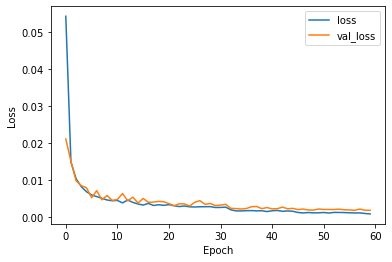

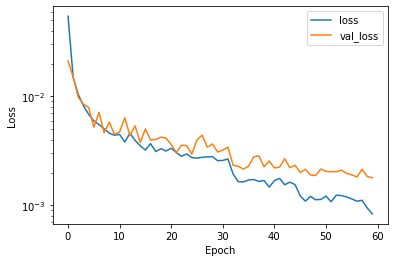

In [28]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.semilogy(hist.history['loss'], label='loss')
plt.semilogy(hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test on simulated data

Initialize the Prediction object for the given model and labels.

In [29]:
pr = Prediction('output/simple_model/models/' + timestamp + '.h5', op.used_label_names)

In [30]:
pred_test_labels = pr.predict_labels(test_reflectivity_pp) # Predict labels for simulated test data

Finished 'predict_labels' in 0.0791 secs


In [31]:
pred_test_labels

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.708092,0.001814,0.077536,0.103505
1,0.234699,0.637629,0.863614,0.490462
2,0.542980,0.646348,0.063692,0.427135
3,0.085167,0.024488,0.082307,0.060391
4,0.123602,0.121923,0.171249,0.062912
...,...,...,...,...
495,0.924831,0.358641,0.171306,0.918784
496,0.806925,0.915845,0.143725,0.000000
497,0.806395,0.115264,0.314141,0.430722
498,0.539153,0.666594,0.430002,0.987704


In [32]:
restored_pred_test_labels = op.restore_labels(pred_test_labels) # Reverse preprocessing on predicted test labels

In [33]:
restored_pred_test_labels # Inspect predicted test labels without preprocessing

,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,ambient_sld
0,22.060091,20.507896,1.0,2.5,4.652143,20.1,17.8,2.345570,0.0
1,9.183803,198.536179,1.0,2.5,51.816822,20.1,17.8,7.376006,0.0
2,17.569046,200.977386,1.0,2.5,3.821541,20.1,17.8,6.552756,0.0
3,5.116533,26.856688,1.0,2.5,4.938444,20.1,17.8,1.785086,0.0
4,6.161980,54.138554,1.0,2.5,10.274942,20.1,17.8,1.817859,0.0
...,...,...,...,...,...,...,...,...,...
495,27.955402,120.419365,1.0,2.5,10.278332,20.1,17.8,12.944193,0.0
496,24.748371,276.436462,1.0,2.5,8.623482,20.1,17.8,1.000000,0.0
497,24.733955,52.273815,1.0,2.5,18.848475,20.1,17.8,6.599383,0.0
498,17.464973,206.646347,1.0,2.5,25.800116,20.1,17.8,13.840148,0.0


Compare test labels with predicted test labels.

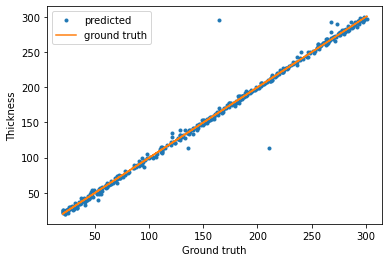

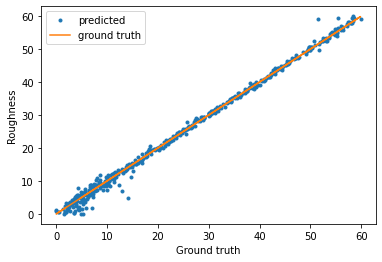

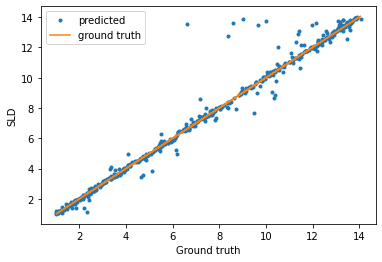

In [34]:
plt.plot(restored_pred_test_labels['Film_thickness'], test_labels['Film_thickness'], '.', label='predicted')
plt.plot(restored_pred_test_labels['Film_thickness'], restored_pred_test_labels['Film_thickness'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('Thickness')
plt.show()

plt.plot(restored_pred_test_labels['Film_roughness'], test_labels['Film_roughness'], '.', label='predicted')
plt.plot(restored_pred_test_labels['Film_roughness'], restored_pred_test_labels['Film_roughness'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('Roughness')
plt.show()

plt.plot(restored_pred_test_labels['Film_sld'], test_labels['Film_sld'], '.', label='predicted')
plt.plot(restored_pred_test_labels['Film_sld'], restored_pred_test_labels['Film_sld'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('SLD')
plt.show()

Simulate reflectivity from predicted labels.

In [35]:
pred_test_reflectivity = gen.simulate_reflectivity(restored_pred_test_labels)

100%|██████████| 500/500 [00:00<00:00, 17491.72it/s]

Finished 'simulate_reflectivity' in 0.0339 secs


Plot test reflectivity with predicted reflectivity

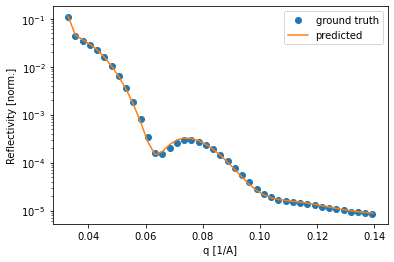

In [36]:
plt.semilogy(q, test_reflectivity[113, :], 'o', label='ground truth')
plt.semilogy(q, pred_test_reflectivity[113, :], label='predicted')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Test on experimental data

In [37]:
experimental_reflectivity_pp = ip.standardize(experimental_reflectivity)

In [38]:
pred_experimental_test_labels = pr.predict_labels(experimental_reflectivity_pp) # Predict labels for experimental test data

Finished 'predict_labels' in 0.0292 secs


In [39]:
restored_pred_experimental_test_labels = op.restore_labels(pred_experimental_test_labels) # Reverse preprocessing on predicted test labels

In [40]:
restored_pred_experimental_test_labels

,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,ambient_sld
0,21.689417,190.008881,1.0,2.5,3.583363,20.1,17.8,1.000000,0.0
1,21.449539,150.495453,1.0,2.5,2.152015,20.1,17.8,1.000000,0.0
2,22.413219,130.070648,1.0,2.5,4.184301,20.1,17.8,1.342874,0.0
3,19.806795,57.232792,1.0,2.5,10.044468,20.1,17.8,2.548793,0.0
4,25.204784,96.728111,1.0,2.5,4.575303,20.1,17.8,2.811854,0.0
...,...,...,...,...,...,...,...,...,...
64,8.450079,146.802460,1.0,2.5,29.206284,20.1,17.8,11.958606,0.0
65,8.795722,149.014252,1.0,2.5,29.146492,20.1,17.8,11.930980,0.0
66,8.313885,152.607986,1.0,2.5,30.001921,20.1,17.8,12.005099,0.0
67,8.678340,153.560883,1.0,2.5,29.651125,20.1,17.8,11.952325,0.0


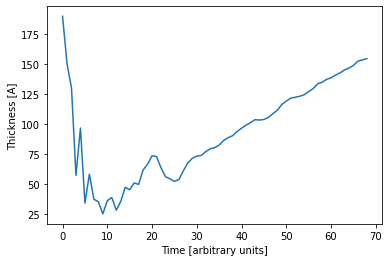

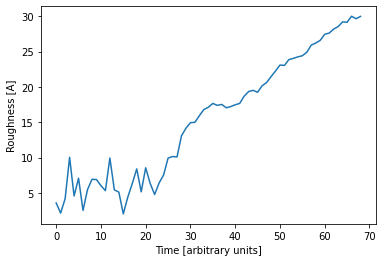

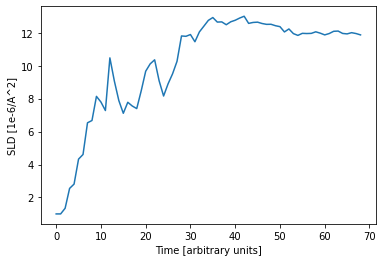

In [41]:
plt.plot(restored_pred_experimental_test_labels['Film_thickness'])
plt.xlabel('Time [arbitrary units]')
plt.ylabel('Thickness [A]')
plt.show()

plt.plot(restored_pred_experimental_test_labels['Film_roughness'])
plt.xlabel('Time [arbitrary units]')
plt.ylabel('Roughness [A]')
plt.show()

plt.plot(restored_pred_experimental_test_labels['Film_sld'])
plt.xlabel('Time [arbitrary units]')
plt.ylabel('SLD [1e-6/A^2]')
plt.show()

In [42]:
pred_experimental_reflectivity = gen.simulate_reflectivity(restored_pred_experimental_test_labels)

100%|██████████| 69/69 [00:00<00:00, 16157.16it/s]

Finished 'simulate_reflectivity' in 0.0073 secs


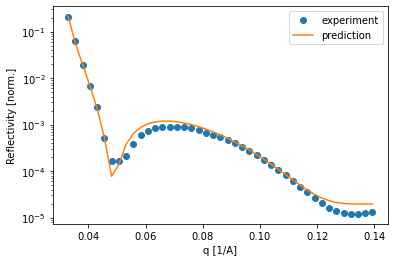

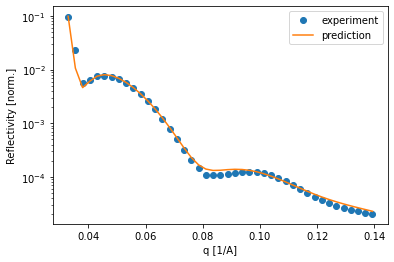

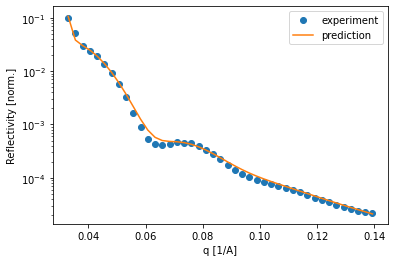

In [43]:
plt.semilogy(q, experimental_reflectivity[30, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[30, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

plt.semilogy(q, experimental_reflectivity[50, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[50, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

plt.semilogy(q, experimental_reflectivity[-1, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[-1, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()